In [10]:
import os
import pandas as pd
import numpy as np
import torch
import seaborn as sns
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
from gluonts.dataset.loader import TrainDataLoader, ValidationDataLoader, InferenceDataLoader
from gluonts.torch.batchify import batchify
from gluonts.transform import AddAgeFeature, Chain, InstanceSplitter
from gluonts.transform.sampler import ExpectedNumInstanceSampler, PredictionSplitSampler

import matplotlib.pyplot as plt

# Import and explore the data

## Initial state

In [11]:
initial_state = pd.read_csv(os.path.join(os.getcwd(), 'data', 'Week 0 - 2024-04-08 - Initial State.csv'))
initial_state.set_index(['Store', "Product"], inplace=True)
initial_state

Start Inventory  Sales  Missed Sales  End Inventory  \
Store Product                                                        
0     126                    0      0             0              3   
      182                    0      0             0              1   
1     124                    0      0             0              6   
2     124                    0      0             0              9   
      126                    0      0             0              3   
...                        ...    ...           ...            ...   
64    193                    0      0             0              1   
      238                    0      0             0              2   
65    126                    0      0             0              3   
66    124                    0      0             0              8   
      126                    0      0             0              2   

               In Transit W+1  In Transit W+2  Holding Cost  Shortage Cost  \
Store Product                                                                
0     126                   0               3             0              0   
      182                   0               1             0              0   
1     124                   0               6             0              0   
2     124                   0               7             0              0   
      126                   0               1             0              0   
...                       ...             ...           ...            ...   
64    193                   0               0             0              0   
      238                   0               0             0              0   
65    126                   0               3             0              0   
66    124                   0               6             0              0   
      126                   0               2             0              0   

               Cumulative Holding Cost  Cumulative Shortage Cost  
Store Product                                                     
0     126                            0                         0  
      182                            0                         0  
1     124                            0                         0  
2     124                            0                         0  
      126                            0                         0  
...                                ...                       ...  
64    193                            0                         0  
      238                            0                         0  
65    126                            0                         0  
66    124                            0                         0  
      126                            0                         0  

[599 rows x 10 columns]

In [12]:
initial_state.any()

Start Inventory             False
Sales                       False
Missed Sales                False
End Inventory                True
In Transit W+1              False
In Transit W+2               True
Holding Cost                False
Shortage Cost               False
Cumulative Holding Cost     False
Cumulative Shortage Cost    False
dtype: bool

## In Stock

In [13]:
in_stock = pd.read_csv(os.path.join(os.getcwd(), 'data', 'Week 0 - In Stock.csv'))
in_stock.set_index(['Store', "Product"], inplace=True)
in_stock

2021-04-12  2021-04-19  2021-04-26  2021-05-03  2021-05-10  \
Store Product                                                               
0     126            True        True        True        True        True   
      182           False       False       False       False       False   
1     124            True        True        True        True        True   
2     124            True        True        True        True        True   
      126           False       False        True        True        True   
...                   ...         ...         ...         ...         ...   
64    193           False       False       False       False       False   
      238           False       False       False        True        True   
65    126            True        True        True        True        True   
66    124           False       False       False       False       False   
      126           False       False       False       False       False   

               2021-05-17  2021-05-24  2021-05-31  2021-06-07  2021-06-14  \
Store Product                                                               
0     126            True        True        True        True        True   
      182           False       False       False       False       False   
1     124            True        True        True        True        True   
2     124            True        True        True        True        True   
      126            True        True        True        True        True   
...                   ...         ...         ...         ...         ...   
64    193           False       False       False       False       False   
      238            True        True        True        True        True   
65    126            True        True        True        True        True   
66    124           False       False       False        True       False   
      126           False       False       False        True        True   

               ...  2024-04-01  2024-04-08  2024-04-15  2024-04-22  \
Store Product  ...                                                   
0     126      ...        True        True        True        True   
      182      ...        True        True        True        True   
1     124      ...        True        True        True        True   
2     124      ...        True        True        True        True   
      126      ...        True        True        True        True   
...            ...         ...         ...         ...         ...   
64    193      ...        True        True        True        True   
      238      ...        True        True        True        True   
65    126      ...        True        True        True        True   
66    124      ...        True        True        True        True   
      126      ...        True        True        True        True   

               2024-04-29  2024-05-06  2024-05-13  2024-05-20  2024-05-27  \
Store Product                                                               
0     126            True        True        True        True        True   
      182            True        True        True        True        True   
1     124            True        True        True        True        True   
2     124            True        True        True        True        True   
      126            True        True        True        True        True   
...                   ...         ...         ...         ...         ...   
64    193            True        True        True        True        True   
      238            True        True        True        True        True   
65    126            True        True        True        True        True   
66    124            True        True        True        True        True   
      126            True        True        True        True        True   

               2024-06-03  
Store Product              
0     126            True  
      182     

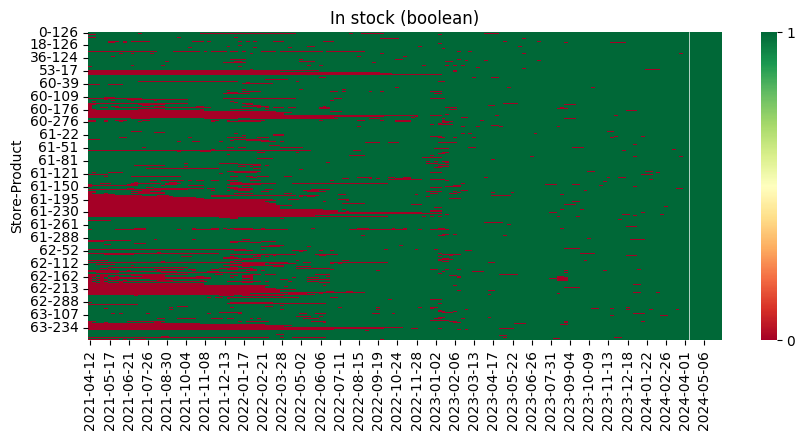

In [14]:
plt.figure(figsize=(9,4.5))
sns.heatmap(in_stock, cbar=True, cmap="RdYlGn", vmin=0, vmax=1,cbar_kws={"ticks": [0, 1]})
plt.axvline(in_stock.columns.get_loc(in_stock.columns[-9])+.5, color='w', linewidth=0.5)
plt.title("In stock (boolean)")
plt.tight_layout()
plt.show()

## Sales

In [15]:
sales = pd.read_csv(os.path.join(os.getcwd(), 'data', 'Week 0 - 2024-04-08 - Sales.csv'))
sales.set_index(['Store', "Product"], inplace=True)
sales

2021-04-12  2021-04-19  2021-04-26  2021-05-03  2021-05-10  \
Store Product                                                               
0     126             0.0         0.0         3.0         3.0         0.0   
      182             0.0         0.0         0.0         0.0         0.0   
1     124            13.0         4.0        10.0         5.0         1.0   
2     124             5.0         5.0        12.0        16.0        10.0   
      126             0.0         0.0         6.0         5.0         7.0   
...                   ...         ...         ...         ...         ...   
64    193             0.0         0.0         0.0         0.0         0.0   
      238             0.0         0.0         0.0         0.0         1.0   
65    126             5.0         2.0         3.0         3.0         2.0   
66    124             0.0         0.0         0.0         0.0         0.0   
      126             0.0         0.0         0.0         0.0         0.0   

               2021-05-17  2021-05-24  2021-05-31  2021-06-07  2021-06-14  \
Store Product                                                               
0     126             1.0         1.0         0.0         1.0         0.0   
      182             0.0         0.0         0.0         0.0         0.0   
1     124             2.0         3.0         4.0         2.0         1.0   
2     124             8.0        10.0         9.0         7.0        10.0   
      126             4.0         1.0         2.0         6.0         5.0   
...                   ...         ...         ...         ...         ...   
64    193             0.0         0.0         0.0         0.0         0.0   
      238             0.0         1.0         0.0         0.0         1.0   
65    126             6.0         2.0         3.0         5.0         1.0   
66    124             0.0         0.0         0.0         2.0         0.0   
      126             0.0         0.0         0.0         1.0         3.0   

               ...  2024-02-05  2024-02-12  2024-02-19  2024-02-26  \
Store Product  ...                                                   
0     126      ...         0.0         2.0         2.0         0.0   
      182      ...         1.0         1.0         0.0         0.0   
1     124      ...         8.0        17.0         6.0        11.0   
2     124      ...         6.0         8.0         8.0        18.0   
      126      ...         2.0         0.0         2.0         5.0   
...            ...         ...         ...         ...         ...   
64    193      ...         1.0         0.0         0.0         0.0   
      238      ...         1.0         0.0         0.0         0.0   
65    126      ...         0.0         0.0         0.0        12.0   
66    124      ...         3.0         5.0         9.0        11.0   
      126      ...         2.0         0.0         6.0         9.0   

               2024-03-04  2024-03-11  2024-03-18  2024-03-25  2024-04-01  \
Store Product                                                               
0     126             0.0         0.0         0.0         0.0         2.0   
      182             1.0         1.0         0.0         3.0         1.0   
1     124             8.0        12.0         6.0         7.0         9.0   
2     124            11.0        14.0         3.0        12.0        13.0   
      126             2.0         2.0         4.0         2.0         3.0   
...                   ...         ...         ...         ...         ...   
64    193             2.0         0.0         1.0         1.0         2.0   
      238             0.0         1.0         2.0         1.0         1.0   
65    126             5.0         0.0         8.0         0.0        16.0   
66    124             8.0         5.0         4.0         7.0         6.0   
      126             0.0         0.0         0.0         8.0         2.0   

               2024-04-08  
Store Product              
0     126             2.0  
      182     

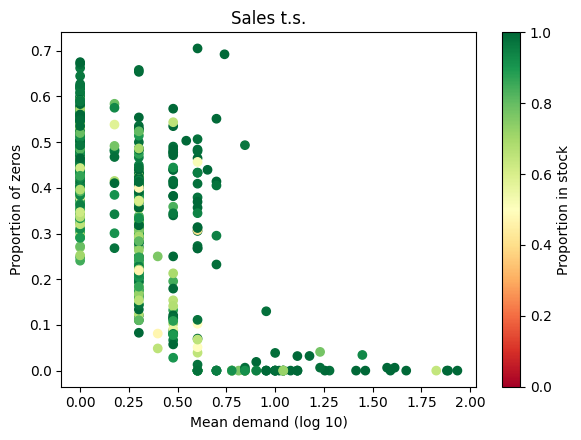

In [16]:
prop_zero, mean_demand, prop_in_stock = [], [], []

for item in sales.index:
    
    ts_raw = np.array(sales.loc[item])
    idx_in_stock = in_stock.loc[item][:-8]
    ts_in_stock = ts_raw[idx_in_stock]

    prop_zero.append(np.mean(ts_in_stock == 0).item())
    mean_demand.append(np.median(ts_in_stock[ts_in_stock > 0.]).item())
    prop_in_stock.append(np.mean(idx_in_stock > 0).item())


plt.figure(figsize=(6, 4.5))

plt.scatter(np.log10(mean_demand), prop_zero, c=prop_in_stock, cmap ="RdYlGn", vmin=0, vmax=1)
plt.colorbar(cmap ="RdYlGn", label="Proportion in stock")
plt.xlabel("Mean demand (log 10)")
plt.ylabel("Proportion of zeros")
plt.title("Sales t.s.")
plt.tight_layout()
plt.show()
    

## Master

In [18]:
master = pd.read_csv(os.path.join(os.getcwd(), 'data', 'Week 0 - Master.csv'))
master.set_index(['Store', "Product"], inplace=True)
master['Store'] = master.index.get_level_values('Store')
master['Product'] = master.index.get_level_values('Product')
master

ProductGroup  Division  Department  DepartmentGroup  \
Store Product                                                        
0     126            301202      3012          30               11   
      182            440403      4404          44               11   
1     124            240201      2402          24               11   
2     124            240201      2402          24               11   
      126            301202      3012          30               11   
...                     ...       ...         ...              ...   
64    193             90214       902           9               11   
      238             90529       905           9               11   
65    126            301202      3012          30               11   
66    124            240201      2402          24               11   
      126            301202      3012          30               11   

               StoreFormat  Format  Store  Product  
Store Product                                       
0     126                1      13      0      126  
      182                1      13      0      182  
1     124                1      13      1      124  
2     124                1      13      2      124  
      126                1      13      2      126  
...                    ...     ...    ...      ...  
64    193                2     216     64      193  
      238                2     216     64      238  
65    126                5     521     65      126  
66    124                5     521     66      124  
      126                5     521     66      126  

[599 rows x 8 columns]

In [23]:
for col in master.columns:
    print(col, f'[# {len(master[col].unique())}]', '\n', master[col].unique(), '\n')

ProductGroup [# 111] 
 [301202 440403 240201  40215 440402 200303 260001 260005 260006 260007
 140402 140513 200207  20318  20319 470209 200408 200409 200503 200611
 530401 200508 140605 280614 400007 330011 401001 401003 401004 400011
 200606 590001 401009 400702 580003 400906 400102 450001 400104 301241
 301240 301239 440404 470202 170602  30103 232202 470305 470211  40209
 200106 200304 140514 200302 470205 200417 200601 200206 371001 280613
 250406 400905 330013 411007 200607 371004 200405 400205 200416 200308
 400002 250401 540006 540008 540101 540010 540301 580007 400903 410801
 140423  40214  40217 400901 400107 400101 200509 140413 440405 400604
 250404  90529 250301 440408 170611  30104 470302 470207 290113  50910
 470213 200610 401005 400201 200307 400105 470103  90220 300906  90501
  90214] 

Division [# 47] 
 [3012 4404 2402  402 2003 2600 1404 1405 2002  203 4702 2004 2005 2006
 5304 1406 2806 4000 3300 4010 5900 4007 5800 4009 4001 4500 1706  301
 2322 4703 2001 3710 2504

In [26]:
coded_master = master.apply(lambda col: pd.Categorical(col).codes)
coded_master

ProductGroup  Division  Department  DepartmentGroup  \
Store Product                                                        
0     126                56        24          14                4   
      182                88        36          19                4   
1     124                43        17           9                4   
2     124                43        17           9                4   
      126                56        24          14                4   
...                     ...       ...         ...              ...   
64    193                 9         4           4                4   
      238                12         5           4                4   
65    126                56        24          14                4   
66    124                43        17           9                4   
      126                56        24          14                4   

               StoreFormat  Format  Store  Product  
Store Product                                       
0     126                0       0      0      126  
      182                0       0      0      182  
1     124                0       0      1      124  
2     124                0       0      2      124  
      126                0       0      2      126  
...                    ...     ...    ...      ...  
64    193                1       1     64      193  
      238                1       1     64      238  
65    126                2       2     65      126  
66    124                2       2     66      124  
      126                2       2     66      126  

[599 rows x 8 columns]

# GluonTS / Torch dataloaders

In [ ]:
T = 157
h = 2
context = 55

datasets = {'train' : [], 'validation' : [], "test" : [], "competition" : []}
dt = sales.columns
datetimes = {
    'train' : dt[:T-2*h],
    'validation' : dt[:T-h],
    'test' : dt[:T],
    'competition' : dt[:157]
}

for idx in sales.index:
    ts_sales, ts_in_stock = sales.loc[idx], in_stock.loc[idx[:-8]]

    for key in datasets.keys():

        dt = datetimes[key]
        datasets[key].append(
            {
                FieldName.ITEM_ID : idx,
                FieldName.START : dt[0],
                FieldName.TARGET : sales.loc[idx].loc[dt].values,
                FieldName.OBSERVED_VALUES : in_stock.loc[idx].loc[dt].values,
                FieldName.FEAT_STATIC_CAT : coded_master.loc[idx].values
            }
        )


for key in datasets.keys():
    datasets[key] = ListDataset(datasets[key], freq="W")



# T = 15
# h = 2
# context = 3

# max_times = {'train' : T-h, 'validation' : T, "test" : T+h, "competition" : T+h}
# datasets = {'train' : [], 'validation' : [], "test" : [], "competition" : []}
# for key in datasets.keys():
#     datasets[key].append(
#              {
#                 "start" : pd.Timestamp('2020-01-01'),
#                 "target" : np.arange(17)[:max_times[key]],
#                 "observed_values" : np.repeat(1, max_times[key]),
#             }
#         )



# for key in datasets.keys():
#     datasets[key] = ListDataset(datasets[key], freq="W")



In [ ]:
transforms = {}

samplers = {
    "train": ExpectedNumInstanceSampler(num_instances=1, min_future=h),
    "validation" : PredictionSplitSampler(min_future=h),
    "test" : PredictionSplitSampler(min_future=h),
    "competition" : PredictionSplitSampler()
    }


for key in datasets.keys():

    transforms[key] = Chain([
    AddAgeFeature(
        target_field=FieldName.TARGET,
        output_field=FieldName.FEAT_DYNAMIC_REAL,
        pred_length=h
    ),
    InstanceSplitter(
        target_field=FieldName.TARGET,
        past_length=context,
        future_length=h,
        instance_sampler=samplers[key],
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        is_pad_field=FieldName.IS_PAD,
        time_series_fields=[FieldName.FEAT_DYNAMIC_REAL, FieldName.OBSERVED_VALUES],
    )
])






In [ ]:
train_loader = TrainDataLoader(
    dataset=datasets['train'],
    transform=transforms['train'], 
    batch_size=32,
    num_batches_per_epoch=25,
    stack_fn = batchify
)

validation_loader = ValidationDataLoader(
    dataset=datasets['validation'],
    transform=transforms['validation'], 
    batch_size=32,
    stack_fn = batchify
)

test_loader = InferenceDataLoader(
    dataset=datasets['test'],
    transform=transforms['test'],  
    batch_size=32,
    stack_fn=batchify
)

competition_loader = ValidationDataLoader(
    dataset=datasets['competition'],
    transform=transforms['competition'], 
    batch_size=32,
    stack_fn=batchify
)



In [ ]:
from gluonts.torch.model.deepar.module import DeepARModel
from gluonts.torch.distributions import NegativeBinomialOutput

model = DeepARModel(
    freq="W",
    prediction_length=h,
    context_length=context,
    num_feat_dynamic_real=1,
    num_feat_static_cat=6,
    num_feat_static_real=1,
    cardinality = [coded_master[col].nunique() for col in coded_master.columns],
    embedding_dimension = [10, 7, 5, 3, 2, 2],
    num_layers = 2,
    hidden_size= 20,
    distr_output=NegativeBinomialOutput(),
    scaling=False,
    #lags_seq=[1],
    num_parallel_samples = 200
)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        

for epoch in range(30):

    train_loss, validation_loss = 0., 0.

    model.train()
    for i, batch in enumerate(train_loader):
        
        optimizer.zero_grad()

        loss = model.loss(
            feat_static_cat = batch[FieldName.FEAT_STATIC_CAT],
            feat_static_real = torch.zeros([len(batch["past_"+FieldName.FEAT_DYNAMIC_REAL]), 1]),
            past_time_feat = batch["past_"+FieldName.FEAT_DYNAMIC_REAL],
            past_target = batch["past_"+FieldName.TARGET],
            past_observed_values = batch["past_"+FieldName.OBSERVED_VALUES],
            future_time_feat = batch["future_"+FieldName.FEAT_DYNAMIC_REAL],
            future_target = batch["future_"+FieldName.TARGET],
            future_observed_values = batch["future_"+FieldName.OBSERVED_VALUES],
            future_only = True).mean()
        
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

    train_loss = train_loss/(i+1)

    for i, batch in enumerate(validation_loader):

        loss = model.loss(
            feat_static_cat = batch[FieldName.FEAT_STATIC_CAT],
            feat_static_real = torch.zeros([len(batch["past_"+FieldName.FEAT_DYNAMIC_REAL]), 1]),
            past_time_feat = batch["past_"+FieldName.FEAT_DYNAMIC_REAL],
            past_target = batch["past_"+FieldName.TARGET],
            past_observed_values = batch["past_"+FieldName.OBSERVED_VALUES],
            future_time_feat = batch["future_"+FieldName.FEAT_DYNAMIC_REAL],
            future_target = batch["future_"+FieldName.TARGET],
            future_observed_values = batch["future_"+FieldName.OBSERVED_VALUES],
            future_only = True).mean()
        
        validation_loss += loss.item()

    validation_loss = validation_loss/(i+1)

    print(train_loss, validation_loss)


    






    

    



AssertionError: lags cannot go further than prior sequence length, found lag 156 while prior sequence is only 0-long

In [ ]:
forecast_samples = []

model.eval()
for batch in test_loader:

    pred = model.forward(
        feat_static_cat = batch[FieldName.FEAT_STATIC_CAT],
        feat_static_real = torch.zeros([len(batch["past_"+FieldName.FEAT_DYNAMIC_REAL]), 1]),
        past_time_feat = batch["past_"+FieldName.FEAT_DYNAMIC_REAL],
        past_target = batch["past_"+FieldName.TARGET],
        past_observed_values = batch["past_"+FieldName.OBSERVED_VALUES],
        future_time_feat = batch["future_"+FieldName.FEAT_DYNAMIC_REAL]
        )
    
    forecast_samples.append(pred.detach().numpy())

forecast_samples = np.vstack(forecast_samples).shape

(599, 200, 2)

In [ ]:
from gluonts.time_feature import (
    time_features_from_frequency_str,
    TimeFeature,
    get_lags_for_frequency,
)

get_lags_for_frequency("W", lag_ub=150)

[1, 2, 3, 4, 5, 6, 7, 8, 12, 51, 52, 53, 103, 104, 105]

In [ ]:
import os
import pandas as pd
import numpy as np
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
from gluonts.dataset.loader import TrainDataLoader, ValidationDataLoader, InferenceDataLoader
from gluonts.torch.batchify import batchify
from gluonts.transform import AddAgeFeature, Chain, InstanceSplitter
from gluonts.transform.sampler import ExpectedNumInstanceSampler, PredictionSplitSampler



def import_raw_data(path = os.path.join(os.getcwd(), "data"), code_master = True):

    sales = pd.read_csv(os.path.join(path, 'Week 0 - 2024-04-08 - Sales.csv'))
    sales.set_index(['Store', "Product"], inplace=True)

    in_stock = pd.read_csv(os.path.join(path, 'Week 0 - In Stock.csv'))
    in_stock.set_index(['Store', "Product"], inplace=True)

    master = pd.read_csv(os.path.join(os.getcwd(), 'data', 'Week 0 - Master.csv'))
    master.set_index(['Store', "Product"], inplace=True)
    master = master.apply(lambda col: pd.Categorical(col).codes) if code_master else master

    return sales, in_stock, master


    

def make_dataloaders(raw_datasets, T, h, batch_size = 32):

    sales, in_stock, master = raw_datasets

    datasets = {'train' : [], 'validation' : [], "test" : [], "competition" : []}
    ts_len = {'train' : T-2*h, 'validation' : T-h, 'test' : T, 'competition' : 157}

    for idx in sales.index:

        for key in datasets.keys():

            datasets[key].append(
                {
                    FieldName.ITEM_ID : idx,
                    FieldName.START : sales.columns[0],
                    FieldName.TARGET : sales.loc[idx][:ts_len[key]].values,
                    FieldName.OBSERVED_VALUES : in_stock.loc[idx][:ts_len[key]].values,
                    FieldName.FEAT_STATIC_CAT : master.loc[idx].values
                }
            )


    for key in datasets.keys():
        datasets[key] = ListDataset(datasets[key], freq="W")

    transforms = {}
    samplers = {
        "train": ExpectedNumInstanceSampler(num_instances=1, min_future=h),
        "validation" : PredictionSplitSampler(min_future=h),
        "test" : PredictionSplitSampler(min_future=h),
        "competition" : PredictionSplitSampler()
    }

    for key in datasets.keys():

        transforms[key] = Chain([
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_DYNAMIC_REAL,
                pred_length=h,
            ),
            InstanceSplitter(
                target_field=FieldName.TARGET,
                past_length=ts_len[key] - (h * key!="competition"),
                future_length=h,
                instance_sampler=samplers[key],
                start_field=FieldName.START,
                forecast_start_field=FieldName.FORECAST_START,
                is_pad_field=FieldName.IS_PAD,
                time_series_fields=[FieldName.FEAT_DYNAMIC_REAL, FieldName.OBSERVED_VALUES]
            )
        ])

    train_loader = TrainDataLoader(
        dataset=datasets['train'],
        transform=transforms['train'], 
        batch_size=32,
        num_batches_per_epoch=25,
        stack_fn = batchify
    )

    validation_loader = ValidationDataLoader(
        dataset=datasets['validation'],
        transform=transforms['validation'], 
        batch_size=32,
        stack_fn = batchify
    )

    test_loader = InferenceDataLoader(
        dataset=datasets['test'],
        transform=transforms['test'],  
        batch_size=32,
        stack_fn=batchify
    )

    competition_loader = ValidationDataLoader(
        dataset=datasets['competition'],
        transform=transforms['competition'], 
        batch_size=32,
        stack_fn=batchify
    )

    return train_loader, validation_loader, test_loader, competition_loader


/Users/stefano.damato/anaconda3/envs/gpint/lib/python3.11/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [4]:
raw_datasets = import_raw_data()

loaders = make_dataloaders(
    raw_datasets, 140, 2, 32
)



In [5]:
for loader in loaders:

    batch = next(iter(loader))

    print(batch['past_target'][0], batch['future_target'][0])

tensor([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   2.,   3.,
          4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,  14.,  15.,
         16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,
         28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,
         40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,
         52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,
         64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,
         76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
         88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
        100., 101., 102., 103., 104., 105., 106., 107., 108., 109., 110., 111.,
        112., 113., 114.]) tensor([115., 116.])
tensor([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.

In [10]:
from utils import import_raw_data
import numpy as np
import pandas as pd

_, _, master = import_raw_data()

def matrix_from_columns(master, hierarchy=1):

    # select which of the two hierachies to use
    assert type(hierarchy) in [int, list]
    if type(hierarchy) == int:
        if hierarchy == 1:
            columns = ["Product", "Division",	"Department",	"DepartmentGroup"]
        elif hierarchy == 2:
            columns = ["Store", "Format"]
    elif type(hierarchy) == list:
        columns = hierarchy

    # iterate through each value of each aggregation level
    A = []
    for col in columns:
        for j in sorted(master[col].unique()):
            idx = master[col] == j
            A.append(np.array(idx.values, np.int32)) 
            for a in A[:-2]:
                if np.all(a == A[-1]):
                    print(col, j)
    return np.array(A)

matrix_from_columns(master, 1).shape

Division 3
Division 8
Division 18
Division 22
Division 23
Division 30
Division 35
Division 38
Division 44
Division 46
Department 0
Department 1
Department 2
Department 3
Department 3
Department 6
Department 8
Department 9
Department 11
Department 12
Department 13
Department 13
Department 15
Department 16
Department 19
Department 20
Department 22
Department 24
Department 25
Department 25
DepartmentGroup 0
DepartmentGroup 0


(376, 599)